### Import

In [1]:
import importlib
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [2]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [3]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Calculate Statistics function

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





## PneumoniaMNIST: NN

In [6]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [7]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes, image_height, image_width):
        super(SimpleCNN, self).__init__()
        #Convoluional layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224x224 -> 112x112
        
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112x112 -> 56x56
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56x56 -> 28x28
        
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        )

        # --- DYNAMIC FLATTENED SIZE CALCULATION ---
        # Create a dummy tensor with the specified input dimensions
        dummy_input = torch.randn(1, in_channels, image_height, image_width)
        # Pass it through the feature extractor to see the output shape
        dummy_output = self.features(dummy_input)
        # The number of elements in the output tensor is our flattened size
        self.flattened_size = dummy_output.numel()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu_fc = nn.ReLU()
        # Output layer: num_classes=1 for binary classification (outputting logits)
        self.fc2 = nn.Linear(512, num_classes)

    def extract_features(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc1(x)
        x = self.relu_fc(x)
        return x

    def forward(self, x):
        x = self.extract_features(x)
        x = self.fc2(x)
        return x

### Lightning module

In [9]:
import torchmetrics
import pytorch_lightning as pl

class LitSimpleCNN(pl.LightningModule):
    def __init__(self, in_channels, num_classes, learning_rate, image_height, image_width, training_mode='full_network'):
        super().__init__()
        # Save hyperparameters
        self.save_hyperparameters()
        
        # Define the model
        self.model = SimpleCNN(
            in_channels=self.hparams.in_channels, 
            num_classes=self.hparams.num_classes,
            image_height=self.hparams.image_height,
            image_width=self.hparams.image_width
        )
        
        # Define loss function
        self.criterion = nn.BCEWithLogitsLoss()

        # Define metrics
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_auc = torchmetrics.AUROC(task="binary")

        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary")
        self.test_recall = torchmetrics.Recall(task="binary")
        self.test_f1 = torchmetrics.F1Score(task="binary")

        # This list will store outputs from each test step
        self.last_test_results = {}
        self.test_step_outputs = []


    def forward(self, x):
        return self.model(x)
    
    def freeze_feature_extractor(self):
        print("Freezing feature extractor layers...")
        for param in self.model.features.parameters():
            param.requires_grad = False
        for param in self.model.fc1.parameters():
            param.requires_grad = False

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        # For BCEWithLogitsLoss, labels must be float
        labels = labels.float()
        
        outputs = self(inputs) # Forward pass
        loss = self.criterion(outputs, labels)

        # We need to handle which part of the network we are training
        if self.hparams.training_mode == 'full_network':
            self.log('train_loss_full', loss)
        elif self.hparams.training_mode == 'classifier_only':
            self.log('train_loss_classifier', loss)
        
        # Log metrics
        self.train_accuracy(outputs, labels.int())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float()
        
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        
        # Log metrics
        self.val_accuracy(outputs, labels.int())
        self.val_auc(outputs, labels.int())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_auc', self.val_auc, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels.float())
        
        # Append predictions and labels to our list
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        # Log the loss for this batch
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        # Concatenate all predictions and labels from the list we built
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # Calculate final metrics over the entire test set
        test_acc = self.test_accuracy(all_preds, all_labels.int())
        test_auc_val = self.test_auc(all_preds, all_labels.int())
        test_prec = self.test_precision(all_preds, all_labels.int())
        test_rec = self.test_recall(all_preds, all_labels.int())
        test_f1_val = self.test_f1(all_preds, all_labels.int())
        test_cm_val = torchmetrics.functional.confusion_matrix(all_preds, all_labels.int(), task="binary")

        # Log the final metrics
        self.log("test_acc_epoch", test_acc)
        self.log("test_auc_epoch", test_auc_val)

        print(f"\n--- Final Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print(f"Precision: {test_prec:.4f}")
        print(f"Recall: {test_rec:.4f}")
        print(f"F1-Score: {test_f1_val:.4f}")
        print(f"Confusion Matrix:\n{test_cm_val}")
        print("--------------------------\n")

        # Calculate data for the ROC Curve
        fpr, tpr, thresholds = torchmetrics.functional.roc(
            torch.sigmoid(all_preds),
            all_labels.int(),
            task="binary"
        )

        # Store the results to be retrieved later in the main script
        self.last_test_results = {
            "fpr": fpr.cpu(),
            "tpr": tpr.cpu(),
            "auc": test_auc_val,
            "f1": test_f1_val,
            "precision": test_prec,
            "recall": test_rec,
            "cm": test_cm_val,
            "thresholds": thresholds.cpu(),
        }
        # Free up memory
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

### Generate data

In [10]:
from sklearn.model_selection import KFold
train_dataset, test_dataset, val_dataset = generate_data("pneumoniaMNIST")

# Ensure you have your train_loader and val_loader defined here
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset.transform = data_transforms
test_dataset.transform = data_transforms
val_dataset.transform = data_transforms


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
#new_train_loader = data.DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) to be done inside the sample_ratio loop
test_loader = data.DataLoader(test_dataset, batch_size=int(BATCH_SIZE/4), shuffle=False, num_workers=NUM_WORKERS)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

3.0.2
Number of training samples: 4708
Number of test samples: 624
Number of validation samples: 524


In [11]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)
best_model_paths = [] # List to store the path of the best model from each stage

# 1. Instantiate the LightningModule
model = LitSimpleCNN(
    in_channels=NUM_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    training_mode='full_network',  # Change to 'classifier_only' if you want to train only the classifier
    image_height=IMAGE_SIZE,
    image_width=IMAGE_SIZE
)

# Optional: Print model summary
# You need to move the model to a device first for torchsummary to work
# summary(model.to('cuda'), (NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
# model.to('cpu') # Move it back if needed

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints/',
    filename='simple-cnn-full-{epoch:02d}-{val_acc:.2f}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn-full")
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn_test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)


# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitSimpleCNN.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["fpr"], "tpr": results_phase1["tpr"], "thresholds": results_phase1["thresholds"], "name": "Original NN PneumoniaMNIST", "auc": results_phase1["auc"], "model": model}

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


--- Starting Training for 1 epochs on train_loader ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Best model from Phase 1 saved to: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=00-val_acc=0.93-v2.ckpt

--- Testing model from Phase 1 checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=00-val_acc=0.93-v2.ckpt ---


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=00-val_acc=0.93-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=00-val_acc=0.93-v2.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Test Metrics ---
Accuracy: 0.8638
AUC: 0.9229
Precision: 0.8506
Recall: 0.9487
F1-Score: 0.8970
Confusion Matrix:
tensor([[169,  65],
        [ 20, 370]], device='cuda:0')
--------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8637820482254028
     test_auc_epoch         0.9228687286376953
        test_loss           0.35975271463394165
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Undersampling based ROC curve

In [12]:
import numpy as np
from collections import Counter

# --- This block generates the list of ratios for your experiment ---

# 1. Get original class counts from your train_dataset

try:
    original_labels = np.array(train_dataset.labels).flatten()
except AttributeError:
    original_labels = np.array(train_dataset.targets).flatten()

original_counts = Counter(original_labels)
num_pos_original = original_counts.get(1, 0)  
num_neg_original = original_counts.get(0, 0)  
print(f"Original class counts: {num_pos_original} positives, {num_neg_original} negatives")

# The pivot point for your function's logic
orig_sample_ratio = num_pos_original / num_neg_original 

# 2. Define how many steps for each regime
N_POINTS_PER_REGIME = 10  # You can change this

# 3. Generate ratios for Regime 1 (from near 0 up to the pivot)
# This will test scenarios from extreme negative-class dominance up to the original balance.
print(f"Generating ratios for Regime 1 (target ratio < {orig_sample_ratio})...")
ratios_regime1 = np.geomspace(
    start=1/num_neg_original,                      # A small starting ratio (e.g., 1 positive for every 10 negatives)
    stop=orig_sample_ratio,         # Go up to the original ratio
    num=N_POINTS_PER_REGIME,
    endpoint=False                  # Exclude the pivot itself to avoid the 'else' block
)

# 4. Generate ratios for Regime 2 (from the pivot up to 3494)
# This will test scenarios from the original balance up to extreme positive-class dominance.
print(f"Generating ratios for Regime 2 (target ratio > {orig_sample_ratio})...")
ratios_regime2 = np.geomspace(
    start=orig_sample_ratio, # Start just above the pivot
    stop=num_pos_original,                      # Your specified upper limit
    num=N_POINTS_PER_REGIME
)

# 5. Combine, sort, and create the final list for the loop
#    We also add the original ratio to ensure we have a baseline run.
all_ratios = sorted(list(np.concatenate([ratios_regime1, ratios_regime2, [orig_sample_ratio]])))

print(f"\nGenerated {len(all_ratios)} unique sample ratios to test.")
print("First few ratios:", np.round(all_ratios[:5], 3))
print("Last few ratios:", np.round(all_ratios[-5:], 2))

Original class counts: 3494 positives, 1214 negatives
Generating ratios for Regime 1 (target ratio < 2.8780889621087313)...
Generating ratios for Regime 2 (target ratio > 2.8780889621087313)...

Generated 21 unique sample ratios to test.
First few ratios: [0.001 0.002 0.004 0.01  0.022]
Last few ratios: [ 148.78  327.53  721.01 1587.2  3494.  ]


### Undersampling function

In [13]:
from torch.utils.data import Subset
def undersample_dataset(train_dataset, sample_ratio):

    
    
    # Get the labels from the dataset (0 for normal, 1 for pneumonia)
    labels = np.array([item[1] for item in train_dataset])

    # Find the indices for the positive (pneumonia) and negative (normal) classes
    positive_indices = np.where(labels == 1)[0]
    negative_indices = np.where(labels == 0)[0]
    num_orig_positive = len(positive_indices)
    num_orig_negative = len(negative_indices)

    orig_sample_ratio = num_orig_positive / num_orig_negative
    print(f"Original sample ratio (positive:negative): {orig_sample_ratio:.2f}")

    #based on sample ratio find the number of positive or negative samples
    if sample_ratio>orig_sample_ratio:
        neg_samples = int(num_orig_positive / sample_ratio)
        pos_samples = num_orig_positive
        sampled_negative_indices = np.random.choice(negative_indices, neg_samples, replace=False)
        final_indices = np.concatenate([sampled_negative_indices, positive_indices])
    elif sample_ratio<orig_sample_ratio:
        pos_samples = int(sample_ratio * num_orig_negative)
        neg_samples = num_orig_negative
        sampled_positive_indices = np.random.choice(positive_indices, pos_samples, replace=False)
        final_indices = np.concatenate([sampled_positive_indices, negative_indices])
    else:
        pos_samples = num_orig_positive
        neg_samples = num_orig_negative
        final_indices = np.concatenate([positive_indices, negative_indices])
        
    # Shuffle the final indices to mix positive and negative samples
    np.random.shuffle(final_indices)

    # 3. Create the new subset dataset using the combined indices
    new_train_dataset = Subset(train_dataset, final_indices)


    # --- Verification (Optional) ---
    # You can verify the composition of your new dataset

    new_labels = labels[final_indices]
    num_positive = np.sum(new_labels == 1)
    num_negative = np.sum(new_labels == 0)

    print(f"Original dataset size: {len(train_dataset)}")
    print(f"New dataset size: {len(new_train_dataset)}")
    print("-" * 30)
    print(f"Original dataset labels distribution:")
    print(f"Original positive samples (pneumonia): {num_orig_positive}")
    print(f"Original negative samples (normal): {num_orig_negative}")
    print(f"Samples in new dataset:")
    print(f"  - Positive (pneumonia): {num_positive}")
    print(f"  - Negative (normal):    {num_negative}")
    print(f"  - Total:                {len(new_labels)}")

    return new_train_dataset



In [14]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)
best_model_paths = [] # List to store the path of the best model from each stage

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    best_model_paths = [] # List to store the path of the best model from each stage

    # 1. Instantiate the LightningModule
    model = LitSimpleCNN(
        in_channels=NUM_CHANNELS,
        num_classes=NUM_CLASSES,
        learning_rate=LEARNING_RATE,
        training_mode='full_network',  # Change to 'classifier_only' if you want to train only the classifier
        image_height=IMAGE_SIZE,
        image_width=IMAGE_SIZE
    )
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")

    # 4. Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = data.DataLoader(
                      train_dataset,
                      batch_size=BATCH_SIZE,
                      sampler=train_subsampler,
                      num_workers=NUM_WORKERS)
    fold_loader = data.DataLoader(
                    train_dataset,
                    batch_size=BATCH_SIZE,
                    sampler=val_subsampler,
                    num_workers=NUM_WORKERS)
    
    fold_train_subset = torch.utils.data.Subset(train_dataset, train_ids)

    # --- Start the main experimental loop ---
    for i, sample_ratio in enumerate(all_ratios):
        print("="*60)
        print(f"--- STARTING STAGE {i+1} FOR SAMPLE RATIO: {sample_ratio} ---")
        print("="*60)

        
        
        # 1. Create the specific dataloader for this stage
        undersampled_train_dataset = undersample_dataset(fold_train_subset, sample_ratio)
        undersampled_train_loader = data.DataLoader(undersampled_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        
        # 2. Instantiate a NEW checkpoint callback for this specific stage
        checkpoint_callback = ModelCheckpoint(
            monitor='val_acc',
            dirpath=f'checkpoints/stage_{i+1}/',
            filename=f'best-model-{{epoch:02d}}-{{val_acc:.2f}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_ratio_{sample_ratio}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=undersampled_train_loader, val_dataloaders=val_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitSimpleCNN.load_from_checkpoint(best_path_this_stage)
        else:
            print(f"--- Stage {i+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

    print("\n--- FINAL STEP: Evaluating all saved models ---")


    # Loop through each saved model checkpoint
    for i, checkpoint_path in enumerate(best_model_paths):
        print(f"\n--- Testing model from checkpoint: {checkpoint_path} ---")

        # 1. Load the PyTorch model from the checkpoint
        pytorch_model = LitSimpleCNN.load_from_checkpoint(checkpoint_path, strict=False)
        pytorch_model.eval()  # Set model to evaluation mode
        pytorch_model.to('cuda:0') # Move model to GPU

        # --- Generate Predictions for the ENTIRE test set ---
        # We will collect the raw model outputs (logits) and true labels
        all_logits = []
        all_labels = []

        # Wrap the loop in torch.no_grad() for efficiency
        with torch.no_grad():
            for batch in tqdm(fold_loader, desc=f"Predicting with model {i+1}"):
                inputs, labels = batch
                
                # Move data to the GPU
                inputs = inputs.to('cuda:0')
                
                # Get model output (raw logits) for the batch
                logits = pytorch_model(inputs)
                
                # Append batch results to lists (move back to CPU to prevent GPU memory buildup)
                all_logits.append(logits.cpu())
                all_labels.append(labels.cpu())

        # Concatenate all batch results into single tensors
        # These now contain the predictions and labels for the full test set
        full_dataset_logits = torch.cat(all_logits)
        full_dataset_labels = torch.cat(all_labels).int() # Ensure labels are integers

        # --- Now, Calculate ALL Metrics using the generated predictions ---

        # 2. Calculate the full ROC curve data
        # Use the raw logits, torchmetrics will handle applying all thresholds
        array_of_all_fprs, array_of_all_tprs, threshold_vals = torchmetrics.functional.roc(
            preds=full_dataset_logits,
            target=full_dataset_labels,
            task="binary"
        )

        # 3. Calculate confusion matrix based on a hard threshold (e.g., 0.5)
        # Note: The model outputs logits, so the threshold 0.5 for probabilities corresponds to 0.0 for logits.
        hard_preds = (full_dataset_logits > 0.0).int().numpy()
        tn, fp, fn, tp = confusion_matrix(full_dataset_labels.numpy(), hard_preds).ravel()

        # 4. Calculate metrics from the confusion matrix
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # This is also Recall
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
        
        print(f"Results at threshold 0.5: TPR={tpr:.4f}, FPR={fpr:.4f}, F1-Score={f1:.4f}")
        
        # 5. Store the comprehensive results for this model
        list_weighted_clfs.append({
            "fpr": fpr,
            "tpr": tpr,
            "model": pytorch_model, # Optional: store the model object itself
            "threshold": 0.5,
            "full_roc": {
                "fpr": array_of_all_fprs,
                "tpr": array_of_all_tprs,
                "thresholds": threshold_vals
            }
        })
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)

Seed set to 42


--- Starting Fold 1/4 ---
--- STARTING STAGE 1 FOR SAMPLE RATIO: 0.0008237232289950577 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 892
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 0
  - Negative (normal):    892
  - Total:                892


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v2.ckpt to continue...
--- STARTING STAGE 2 FOR SAMPLE RATIO: 0.0018625742875929383 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 893
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 1
  - Negative (normal):    892
  - Total:                893


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26.ckpt to continue...
--- STARTING STAGE 3 FOR SAMPLE RATIO: 0.004211588133838042 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 895
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 3
  - Negative (normal):    892
  - Total:                895


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26.ckpt to continue...
--- STARTING STAGE 4 FOR SAMPLE RATIO: 0.00952309646237416 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 900
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 8
  - Negative (normal):    892
  - Total:                900


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26.ckpt to continue...
--- STARTING STAGE 5 FOR SAMPLE RATIO: 0.02153329417542966 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 911
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 19
  - Negative (normal):    892
  - Total:                911


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26.ckpt to continue...
--- STARTING STAGE 6 FOR SAMPLE RATIO: 0.04869033511081269 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 935
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 43
  - Negative (normal):    892
  - Total:                935


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26.ckpt to continue...
--- STARTING STAGE 7 FOR SAMPLE RATIO: 0.11009689060526352 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 990
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 98
  - Negative (normal):    892
  - Total:                990


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.65.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.65.ckpt to continue...
--- STARTING STAGE 8 FOR SAMPLE RATIO: 0.24894725602854975 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 1114
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 222
  - Negative (normal):    892
  - Total:                1114


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.88.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.88.ckpt to continue...
--- STARTING STAGE 9 FOR SAMPLE RATIO: 0.5629108682673496 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 1394
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 502
  - Negative (normal):    892
  - Total:                1394


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.92.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.92.ckpt to continue...
--- STARTING STAGE 10 FOR SAMPLE RATIO: 1.2728344576618362 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 2027
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 1135
  - Negative (normal):    892
  - Total:                2027


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.96.ckpt to continue...
--- STARTING STAGE 11 FOR SAMPLE RATIO: 2.8780889621087313 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 3459
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 2567
  - Negative (normal):    892
  - Total:                3459


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.97-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.97-v3.ckpt to continue...
--- STARTING STAGE 12 FOR SAMPLE RATIO: 2.8780889621087313 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 3459
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 2567
  - Negative (normal):    892
  - Total:                3459


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.97-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.97-v3.ckpt to continue...
--- STARTING STAGE 13 FOR SAMPLE RATIO: 6.335708376599064 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 3055
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 2639
  - Negative (normal):    416
  - Total:                3055


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.96-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.96-v1.ckpt to continue...
--- STARTING STAGE 14 FOR SAMPLE RATIO: 13.947171599552195 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 2828
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 2639
  - Negative (normal):    189
  - Total:                2828


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.97-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.97-v2.ckpt to continue...
--- STARTING STAGE 15 FOR SAMPLE RATIO: 30.70273820459099 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 2724
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 2639
  - Negative (normal):    85
  - Total:                2724


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.88.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.88.ckpt to continue...
--- STARTING STAGE 16 FOR SAMPLE RATIO: 67.58776333474793 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 2678
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 2639
  - Negative (normal):    39
  - Total:                2678


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.91.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.91.ckpt to continue...
--- STARTING STAGE 17 FOR SAMPLE RATIO: 148.784962505749 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 2656
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 2639
  - Negative (normal):    17
  - Total:                2656


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.86.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.86.ckpt to continue...
--- STARTING STAGE 18 FOR SAMPLE RATIO: 327.52918539702824 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 2647
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 2639
  - Negative (normal):    8
  - Total:                2647


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.74.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.74.ckpt to continue...
--- STARTING STAGE 19 FOR SAMPLE RATIO: 721.0094721951214 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 2642
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 2639
  - Negative (normal):    3
  - Total:                2642


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.88.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.88.ckpt to continue...
--- STARTING STAGE 20 FOR SAMPLE RATIO: 1587.2010256579829 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 2640
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 2639
  - Negative (normal):    1
  - Total:                2640


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.74.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.74.ckpt to continue...
--- STARTING STAGE 21 FOR SAMPLE RATIO: 3494.0 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.96
Original dataset size: 3531
New dataset size: 2639
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2639
Original negative samples (normal): 892
Samples in new dataset:
  - Positive (pneumonia): 2639
  - Negative (normal):    0
  - Total:                2639


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.74.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.74.ckpt to continue...

--- FINAL STEP: Evaluating all saved models ---

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v2.ckpt ---


Predicting with model 1: 100%|██████████| 19/19 [00:00<00:00, 20.20it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26.ckpt ---


Predicting with model 2: 100%|██████████| 19/19 [00:00<00:00, 25.66it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26.ckpt ---


Predicting with model 3: 100%|██████████| 19/19 [00:00<00:00, 24.41it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26.ckpt ---


Predicting with model 4: 100%|██████████| 19/19 [00:00<00:00, 25.92it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26.ckpt ---


Predicting with model 5: 100%|██████████| 19/19 [00:00<00:00, 24.42it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26.ckpt ---


Predicting with model 6: 100%|██████████| 19/19 [00:00<00:00, 24.30it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.65.ckpt ---


Predicting with model 7: 100%|██████████| 19/19 [00:00<00:00, 25.55it/s]


Results at threshold 0.5: TPR=0.5357, FPR=0.0062, F1-Score=0.6966

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.88.ckpt ---


Predicting with model 8: 100%|██████████| 19/19 [00:00<00:00, 23.82it/s]


Results at threshold 0.5: TPR=0.8211, FPR=0.0404, F1-Score=0.8943

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.92.ckpt ---


Predicting with model 9: 100%|██████████| 19/19 [00:00<00:00, 26.03it/s]


Results at threshold 0.5: TPR=0.8994, FPR=0.0404, F1-Score=0.9395

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.96.ckpt ---


Predicting with model 10: 100%|██████████| 19/19 [00:00<00:00, 31.02it/s]


Results at threshold 0.5: TPR=0.9509, FPR=0.0994, F1-Score=0.9565

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.97-v3.ckpt ---


Predicting with model 11: 100%|██████████| 19/19 [00:00<00:00, 29.72it/s]


Results at threshold 0.5: TPR=0.9778, FPR=0.0714, F1-Score=0.9755

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.97-v3.ckpt ---


Predicting with model 12: 100%|██████████| 19/19 [00:00<00:00, 29.12it/s]


Results at threshold 0.5: TPR=0.9778, FPR=0.0652, F1-Score=0.9766

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.96-v1.ckpt ---


Predicting with model 13: 100%|██████████| 19/19 [00:00<00:00, 29.46it/s]


Results at threshold 0.5: TPR=0.9871, FPR=0.1180, F1-Score=0.9718

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.97-v2.ckpt ---


Predicting with model 14: 100%|██████████| 19/19 [00:00<00:00, 30.84it/s]


Results at threshold 0.5: TPR=0.9743, FPR=0.0404, F1-Score=0.9794

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.88.ckpt ---


Predicting with model 15: 100%|██████████| 19/19 [00:00<00:00, 31.07it/s]


Results at threshold 0.5: TPR=0.9988, FPR=0.4876, F1-Score=0.9153

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.91.ckpt ---


Predicting with model 16: 100%|██████████| 19/19 [00:00<00:00, 24.88it/s]


Results at threshold 0.5: TPR=0.9988, FPR=0.3820, F1-Score=0.9323

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.86.ckpt ---


Predicting with model 17: 100%|██████████| 19/19 [00:00<00:00, 24.82it/s]


Results at threshold 0.5: TPR=0.9988, FPR=0.5404, F1-Score=0.9071

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.74.ckpt ---


Predicting with model 18: 100%|██████████| 19/19 [00:00<00:00, 24.16it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.9938, F1-Score=0.8424

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.88.ckpt ---


Predicting with model 19: 100%|██████████| 19/19 [00:01<00:00, 17.27it/s]


Results at threshold 0.5: TPR=0.9988, FPR=0.5435, F1-Score=0.9066

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.74.ckpt ---


Predicting with model 20: 100%|██████████| 19/19 [00:00<00:00, 24.09it/s]


Results at threshold 0.5: TPR=1.0000, FPR=1.0000, F1-Score=0.8415

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.74.ckpt ---


Predicting with model 21: 100%|██████████| 19/19 [00:00<00:00, 24.27it/s]


Results at threshold 0.5: TPR=1.0000, FPR=1.0000, F1-Score=0.8415
--- Starting Fold 2/4 ---
--- STARTING STAGE 1 FOR SAMPLE RATIO: 0.0008237232289950577 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 907
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 0
  - Negative (normal):    907
  - Total:                907


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v3.ckpt to continue...
--- STARTING STAGE 2 FOR SAMPLE RATIO: 0.0018625742875929383 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 908
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 1
  - Negative (normal):    907
  - Total:                908


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v1.ckpt to continue...
--- STARTING STAGE 3 FOR SAMPLE RATIO: 0.004211588133838042 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 910
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 3
  - Negative (normal):    907
  - Total:                910


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v1.ckpt to continue...
--- STARTING STAGE 4 FOR SAMPLE RATIO: 0.00952309646237416 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 915
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 8
  - Negative (normal):    907
  - Total:                915


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26-v1.ckpt to continue...
--- STARTING STAGE 5 FOR SAMPLE RATIO: 0.02153329417542966 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 926
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 19
  - Negative (normal):    907
  - Total:                926


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v1.ckpt to continue...
--- STARTING STAGE 6 FOR SAMPLE RATIO: 0.04869033511081269 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 951
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 44
  - Negative (normal):    907
  - Total:                951


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.30.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.30.ckpt to continue...
--- STARTING STAGE 7 FOR SAMPLE RATIO: 0.11009689060526352 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 1006
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 99
  - Negative (normal):    907
  - Total:                1006


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.83.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.83.ckpt to continue...
--- STARTING STAGE 8 FOR SAMPLE RATIO: 0.24894725602854975 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 1132
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 225
  - Negative (normal):    907
  - Total:                1132


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.81.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.81.ckpt to continue...
--- STARTING STAGE 9 FOR SAMPLE RATIO: 0.5629108682673496 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 1417
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 510
  - Negative (normal):    907
  - Total:                1417


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.92-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.92-v1.ckpt to continue...
--- STARTING STAGE 10 FOR SAMPLE RATIO: 1.2728344576618362 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 2061
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 1154
  - Negative (normal):    907
  - Total:                2061


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.93.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.93.ckpt to continue...
--- STARTING STAGE 11 FOR SAMPLE RATIO: 2.8780889621087313 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 3517
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 2610
  - Negative (normal):    907
  - Total:                3517


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...
--- STARTING STAGE 12 FOR SAMPLE RATIO: 2.8780889621087313 ---


Using 16bit Automatic Mixed Precision (AMP)


Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 3517
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 2610
  - Negative (normal):    907
  - Total:                3517


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.96.ckpt to continue...
--- STARTING STAGE 13 FOR SAMPLE RATIO: 6.335708376599064 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 3038
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 2624
  - Negative (normal):    414
  - Total:                3038


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.97-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.97-v2.ckpt to continue...
--- STARTING STAGE 14 FOR SAMPLE RATIO: 13.947171599552195 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 2812
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 2624
  - Negative (normal):    188
  - Total:                2812


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.96-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.96-v1.ckpt to continue...
--- STARTING STAGE 15 FOR SAMPLE RATIO: 30.70273820459099 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 2709
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 2624
  - Negative (normal):    85
  - Total:                2709


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.91.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.91.ckpt to continue...
--- STARTING STAGE 16 FOR SAMPLE RATIO: 67.58776333474793 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 2662
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 2624
  - Negative (normal):    38
  - Total:                2662


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.86.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.86.ckpt to continue...
--- STARTING STAGE 17 FOR SAMPLE RATIO: 148.784962505749 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 2641
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 2624
  - Negative (normal):    17
  - Total:                2641


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.90.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.90.ckpt to continue...
--- STARTING STAGE 18 FOR SAMPLE RATIO: 327.52918539702824 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 2632
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 2624
  - Negative (normal):    8
  - Total:                2632


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.75.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.75.ckpt to continue...
--- STARTING STAGE 19 FOR SAMPLE RATIO: 721.0094721951214 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 2627
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 2624
  - Negative (normal):    3
  - Total:                2627


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.74.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.74.ckpt to continue...
--- STARTING STAGE 20 FOR SAMPLE RATIO: 1587.2010256579829 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 2625
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 2624
  - Negative (normal):    1
  - Total:                2625


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.74-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.74-v1.ckpt to continue...
--- STARTING STAGE 21 FOR SAMPLE RATIO: 3494.0 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.89
Original dataset size: 3531
New dataset size: 2624
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2624
Original negative samples (normal): 907
Samples in new dataset:
  - Positive (pneumonia): 2624
  - Negative (normal):    0
  - Total:                2624


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.74-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.74-v1.ckpt to continue...

--- FINAL STEP: Evaluating all saved models ---

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v3.ckpt ---


Predicting with model 1: 100%|██████████| 19/19 [00:01<00:00, 18.48it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v1.ckpt ---


Predicting with model 2: 100%|██████████| 19/19 [00:00<00:00, 23.37it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v1.ckpt ---


Predicting with model 3: 100%|██████████| 19/19 [00:00<00:00, 24.06it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26-v1.ckpt ---


Predicting with model 4: 100%|██████████| 19/19 [00:00<00:00, 23.35it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v1.ckpt ---


Predicting with model 5: 100%|██████████| 19/19 [00:00<00:00, 25.33it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.30.ckpt ---


Predicting with model 6: 100%|██████████| 19/19 [00:00<00:00, 22.84it/s]


Results at threshold 0.5: TPR=0.0621, FPR=0.0000, F1-Score=0.1169

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.83.ckpt ---


Predicting with model 7: 100%|██████████| 19/19 [00:01<00:00, 15.70it/s]


Results at threshold 0.5: TPR=0.8023, FPR=0.0293, F1-Score=0.8852

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.81.ckpt ---


Predicting with model 8: 100%|██████████| 19/19 [00:00<00:00, 20.93it/s]


Results at threshold 0.5: TPR=0.7805, FPR=0.0521, F1-Score=0.8677

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.92-v1.ckpt ---


Predicting with model 9: 100%|██████████| 19/19 [00:00<00:00, 22.15it/s]


Results at threshold 0.5: TPR=0.9437, FPR=0.0554, F1-Score=0.9614

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.93.ckpt ---


Predicting with model 10: 100%|██████████| 19/19 [00:00<00:00, 24.14it/s]


Results at threshold 0.5: TPR=0.9080, FPR=0.0228, F1-Score=0.9478

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


Predicting with model 11: 100%|██████████| 19/19 [00:01<00:00, 13.33it/s]


Results at threshold 0.5: TPR=0.9770, FPR=0.0814, F1-Score=0.9742

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.96.ckpt ---


Predicting with model 12: 100%|██████████| 19/19 [00:00<00:00, 21.98it/s]


Results at threshold 0.5: TPR=0.9920, FPR=0.1466, F1-Score=0.9708

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.97-v2.ckpt ---


Predicting with model 13: 100%|██████████| 19/19 [00:00<00:00, 24.40it/s]


Results at threshold 0.5: TPR=0.9701, FPR=0.0586, F1-Score=0.9746

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.96-v1.ckpt ---


Predicting with model 14: 100%|██████████| 19/19 [00:00<00:00, 23.57it/s]


Results at threshold 0.5: TPR=0.9897, FPR=0.1270, F1-Score=0.9729

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.91.ckpt ---


Predicting with model 15: 100%|██████████| 19/19 [00:01<00:00, 14.84it/s]


Results at threshold 0.5: TPR=0.9966, FPR=0.5244, F1-Score=0.9136

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.86.ckpt ---


Predicting with model 16: 100%|██████████| 19/19 [00:00<00:00, 24.89it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.6352, F1-Score=0.8992

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.90.ckpt ---


Predicting with model 17: 100%|██████████| 19/19 [00:00<00:00, 23.46it/s]


Results at threshold 0.5: TPR=0.9977, FPR=0.4365, F1-Score=0.9274

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.75.ckpt ---


Predicting with model 18: 100%|██████████| 19/19 [00:00<00:00, 23.12it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.9707, F1-Score=0.8538

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.74.ckpt ---


Predicting with model 19: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


Results at threshold 0.5: TPR=1.0000, FPR=1.0000, F1-Score=0.8500

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.74-v1.ckpt ---


Predicting with model 20: 100%|██████████| 19/19 [00:00<00:00, 26.64it/s]


Results at threshold 0.5: TPR=1.0000, FPR=1.0000, F1-Score=0.8500

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.74-v1.ckpt ---


Predicting with model 21: 100%|██████████| 19/19 [00:00<00:00, 25.15it/s]


Results at threshold 0.5: TPR=1.0000, FPR=1.0000, F1-Score=0.8500
--- Starting Fold 3/4 ---
--- STARTING STAGE 1 FOR SAMPLE RATIO: 0.0008237232289950577 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 933
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 0
  - Negative (normal):    933
  - Total:                933


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v4.ckpt to continue...
--- STARTING STAGE 2 FOR SAMPLE RATIO: 0.0018625742875929383 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 934
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 1
  - Negative (normal):    933
  - Total:                934


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v2.ckpt to continue...
--- STARTING STAGE 3 FOR SAMPLE RATIO: 0.004211588133838042 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 936
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 3
  - Negative (normal):    933
  - Total:                936


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v2.ckpt to continue...
--- STARTING STAGE 4 FOR SAMPLE RATIO: 0.00952309646237416 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 941
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 8
  - Negative (normal):    933
  - Total:                941


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26-v2.ckpt to continue...
--- STARTING STAGE 5 FOR SAMPLE RATIO: 0.02153329417542966 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 953
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 20
  - Negative (normal):    933
  - Total:                953


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v2.ckpt to continue...
--- STARTING STAGE 6 FOR SAMPLE RATIO: 0.04869033511081269 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 978
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 45
  - Negative (normal):    933
  - Total:                978


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26-v1.ckpt to continue...
--- STARTING STAGE 7 FOR SAMPLE RATIO: 0.11009689060526352 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 1035
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 102
  - Negative (normal):    933
  - Total:                1035


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.52.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.52.ckpt to continue...
--- STARTING STAGE 8 FOR SAMPLE RATIO: 0.24894725602854975 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 1165
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 232
  - Negative (normal):    933
  - Total:                1165


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.87.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.87.ckpt to continue...
--- STARTING STAGE 9 FOR SAMPLE RATIO: 0.5629108682673496 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 1458
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 525
  - Negative (normal):    933
  - Total:                1458


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.91.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.91.ckpt to continue...
--- STARTING STAGE 10 FOR SAMPLE RATIO: 1.2728344576618362 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 2120
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 1187
  - Negative (normal):    933
  - Total:                2120


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.96-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.96-v1.ckpt to continue...
--- STARTING STAGE 11 FOR SAMPLE RATIO: 2.8780889621087313 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 3500
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 2598
  - Negative (normal):    902
  - Total:                3500


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.96.ckpt to continue...
--- STARTING STAGE 12 FOR SAMPLE RATIO: 2.8780889621087313 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 3500
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 2598
  - Negative (normal):    902
  - Total:                3500


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...
--- STARTING STAGE 13 FOR SAMPLE RATIO: 6.335708376599064 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 3008
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 2598
  - Negative (normal):    410
  - Total:                3008


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.95.ckpt to continue...
--- STARTING STAGE 14 FOR SAMPLE RATIO: 13.947171599552195 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 2784
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 2598
  - Negative (normal):    186
  - Total:                2784


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.97-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.97-v3.ckpt to continue...
--- STARTING STAGE 15 FOR SAMPLE RATIO: 30.70273820459099 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 2682
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 2598
  - Negative (normal):    84
  - Total:                2682


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.94.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.94.ckpt to continue...
--- STARTING STAGE 16 FOR SAMPLE RATIO: 67.58776333474793 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 2636
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 2598
  - Negative (normal):    38
  - Total:                2636


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.93.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.93.ckpt to continue...
--- STARTING STAGE 17 FOR SAMPLE RATIO: 148.784962505749 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 2615
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 2598
  - Negative (normal):    17
  - Total:                2615


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.78.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.78.ckpt to continue...
--- STARTING STAGE 18 FOR SAMPLE RATIO: 327.52918539702824 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 2605
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 2598
  - Negative (normal):    7
  - Total:                2605


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.74-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.74-v1.ckpt to continue...
--- STARTING STAGE 19 FOR SAMPLE RATIO: 721.0094721951214 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 2601
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 2598
  - Negative (normal):    3
  - Total:                2601


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.74-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.74-v1.ckpt to continue...
--- STARTING STAGE 20 FOR SAMPLE RATIO: 1587.2010256579829 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 2599
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 2598
  - Negative (normal):    1
  - Total:                2599


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.74-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.74-v2.ckpt to continue...
--- STARTING STAGE 21 FOR SAMPLE RATIO: 3494.0 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.78
Original dataset size: 3531
New dataset size: 2598
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2598
Original negative samples (normal): 933
Samples in new dataset:
  - Positive (pneumonia): 2598
  - Negative (normal):    0
  - Total:                2598


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.74-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.74-v2.ckpt to continue...

--- FINAL STEP: Evaluating all saved models ---

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v4.ckpt ---


Predicting with model 1: 100%|██████████| 19/19 [00:01<00:00, 18.91it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v2.ckpt ---


Predicting with model 2: 100%|██████████| 19/19 [00:00<00:00, 22.62it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v2.ckpt ---


Predicting with model 3: 100%|██████████| 19/19 [00:00<00:00, 20.98it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26-v2.ckpt ---


Predicting with model 4: 100%|██████████| 19/19 [00:00<00:00, 22.57it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v2.ckpt ---


Predicting with model 5: 100%|██████████| 19/19 [00:00<00:00, 22.89it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26-v1.ckpt ---


Predicting with model 6: 100%|██████████| 19/19 [00:00<00:00, 22.67it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.52.ckpt ---


Predicting with model 7: 100%|██████████| 19/19 [00:00<00:00, 22.73it/s]


Results at threshold 0.5: TPR=0.3817, FPR=0.0000, F1-Score=0.5525

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.87.ckpt ---


Predicting with model 8: 100%|██████████| 19/19 [00:01<00:00, 14.98it/s]


Results at threshold 0.5: TPR=0.8426, FPR=0.0036, F1-Score=0.9140

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.91.ckpt ---


Predicting with model 9: 100%|██████████| 19/19 [00:00<00:00, 22.86it/s]


Results at threshold 0.5: TPR=0.9051, FPR=0.0285, F1-Score=0.9458

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.96-v1.ckpt ---


Predicting with model 10: 100%|██████████| 19/19 [00:00<00:00, 27.83it/s]


Results at threshold 0.5: TPR=0.9710, FPR=0.0463, F1-Score=0.9781

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.96.ckpt ---


Predicting with model 11: 100%|██████████| 19/19 [00:00<00:00, 29.48it/s]


Results at threshold 0.5: TPR=0.9810, FPR=0.0569, F1-Score=0.9816

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


Predicting with model 12: 100%|██████████| 19/19 [00:01<00:00, 11.20it/s]


Results at threshold 0.5: TPR=0.9888, FPR=0.0534, F1-Score=0.9861

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 13: 100%|██████████| 19/19 [00:00<00:00, 24.51it/s]


Results at threshold 0.5: TPR=0.9978, FPR=0.1922, F1-Score=0.9696

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.97-v3.ckpt ---


Predicting with model 14: 100%|██████████| 19/19 [00:00<00:00, 22.67it/s]


Results at threshold 0.5: TPR=0.9900, FPR=0.0605, F1-Score=0.9856

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.94.ckpt ---


Predicting with model 15: 100%|██████████| 19/19 [00:00<00:00, 23.87it/s]


Results at threshold 0.5: TPR=0.9978, FPR=0.1922, F1-Score=0.9696

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.93.ckpt ---


Predicting with model 16: 100%|██████████| 19/19 [00:01<00:00, 15.58it/s]


Results at threshold 0.5: TPR=0.9967, FPR=0.2242, F1-Score=0.9644

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.78.ckpt ---


Predicting with model 17: 100%|██████████| 19/19 [00:00<00:00, 22.92it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.8149, F1-Score=0.8867

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.74-v1.ckpt ---


Predicting with model 18: 100%|██████████| 19/19 [00:00<00:00, 23.53it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.9929, F1-Score=0.8653

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.74-v1.ckpt ---


Predicting with model 19: 100%|██████████| 19/19 [00:00<00:00, 21.50it/s]


Results at threshold 0.5: TPR=1.0000, FPR=1.0000, F1-Score=0.8644

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.74-v2.ckpt ---


Predicting with model 20: 100%|██████████| 19/19 [00:01<00:00, 11.38it/s]


Results at threshold 0.5: TPR=1.0000, FPR=1.0000, F1-Score=0.8644

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.74-v2.ckpt ---


Predicting with model 21: 100%|██████████| 19/19 [00:00<00:00, 23.12it/s]


Results at threshold 0.5: TPR=1.0000, FPR=1.0000, F1-Score=0.8644
--- Starting Fold 4/4 ---
--- STARTING STAGE 1 FOR SAMPLE RATIO: 0.0008237232289950577 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 910
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 0
  - Negative (normal):    910
  - Total:                910


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v5.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v5.ckpt to continue...
--- STARTING STAGE 2 FOR SAMPLE RATIO: 0.0018625742875929383 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 911
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 1
  - Negative (normal):    910
  - Total:                911


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v3.ckpt to continue...
--- STARTING STAGE 3 FOR SAMPLE RATIO: 0.004211588133838042 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 913
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 3
  - Negative (normal):    910
  - Total:                913


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v3.ckpt to continue...
--- STARTING STAGE 4 FOR SAMPLE RATIO: 0.00952309646237416 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 918
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 8
  - Negative (normal):    910
  - Total:                918


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26-v3.ckpt to continue...
--- STARTING STAGE 5 FOR SAMPLE RATIO: 0.02153329417542966 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 929
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 19
  - Negative (normal):    910
  - Total:                929


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v3.ckpt to continue...
--- STARTING STAGE 6 FOR SAMPLE RATIO: 0.04869033511081269 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 954
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 44
  - Negative (normal):    910
  - Total:                954


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26-v2.ckpt to continue...
--- STARTING STAGE 7 FOR SAMPLE RATIO: 0.11009689060526352 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 1010
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 100
  - Negative (normal):    910
  - Total:                1010


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.79.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.79.ckpt to continue...
--- STARTING STAGE 8 FOR SAMPLE RATIO: 0.24894725602854975 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 1136
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 226
  - Negative (normal):    910
  - Total:                1136


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.80.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.80.ckpt to continue...
--- STARTING STAGE 9 FOR SAMPLE RATIO: 0.5629108682673496 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 1422
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 512
  - Negative (normal):    910
  - Total:                1422


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.89.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.89.ckpt to continue...
--- STARTING STAGE 10 FOR SAMPLE RATIO: 1.2728344576618362 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 2068
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 1158
  - Negative (normal):    910
  - Total:                2068


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.90.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.90.ckpt to continue...
--- STARTING STAGE 11 FOR SAMPLE RATIO: 2.8780889621087313 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 3529
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 2619
  - Negative (normal):    910
  - Total:                3529


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.96-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.96-v1.ckpt to continue...
--- STARTING STAGE 12 FOR SAMPLE RATIO: 2.8780889621087313 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 3529
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 2619
  - Negative (normal):    910
  - Total:                3529


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.96-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.96-v1.ckpt to continue...
--- STARTING STAGE 13 FOR SAMPLE RATIO: 6.335708376599064 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 3034
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 2621
  - Negative (normal):    413
  - Total:                3034


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.96-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.96-v2.ckpt to continue...
--- STARTING STAGE 14 FOR SAMPLE RATIO: 13.947171599552195 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 2808
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 2621
  - Negative (normal):    187
  - Total:                2808


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.97-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.97-v4.ckpt to continue...
--- STARTING STAGE 15 FOR SAMPLE RATIO: 30.70273820459099 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 2706
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 2621
  - Negative (normal):    85
  - Total:                2706


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.95.ckpt to continue...
--- STARTING STAGE 16 FOR SAMPLE RATIO: 67.58776333474793 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 2659
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 2621
  - Negative (normal):    38
  - Total:                2659


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.97-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.97-v2.ckpt to continue...
--- STARTING STAGE 17 FOR SAMPLE RATIO: 148.784962505749 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 2638
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 2621
  - Negative (normal):    17
  - Total:                2638


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.74.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.74.ckpt to continue...
--- STARTING STAGE 18 FOR SAMPLE RATIO: 327.52918539702824 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 2629
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 2621
  - Negative (normal):    8
  - Total:                2629


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.92.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.92.ckpt to continue...
--- STARTING STAGE 19 FOR SAMPLE RATIO: 721.0094721951214 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 2624
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 2621
  - Negative (normal):    3
  - Total:                2624


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.76.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.76.ckpt to continue...
--- STARTING STAGE 20 FOR SAMPLE RATIO: 1587.2010256579829 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 2622
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 2621
  - Negative (normal):    1
  - Total:                2622


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.74-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.74-v3.ckpt to continue...
--- STARTING STAGE 21 FOR SAMPLE RATIO: 3494.0 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

Original sample ratio (positive:negative): 2.88
Original dataset size: 3531
New dataset size: 2621
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 2621
Original negative samples (normal): 910
Samples in new dataset:
  - Positive (pneumonia): 2621
  - Negative (normal):    0
  - Total:                2621


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.74-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.74-v3.ckpt to continue...

--- FINAL STEP: Evaluating all saved models ---

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v5.ckpt ---


Predicting with model 1: 100%|██████████| 19/19 [00:00<00:00, 19.15it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v3.ckpt ---


Predicting with model 2: 100%|██████████| 19/19 [00:00<00:00, 23.60it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v3.ckpt ---


Predicting with model 3: 100%|██████████| 19/19 [00:00<00:00, 22.79it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26-v3.ckpt ---


Predicting with model 4: 100%|██████████| 19/19 [00:00<00:00, 23.25it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v3.ckpt ---


Predicting with model 5: 100%|██████████| 19/19 [00:00<00:00, 22.55it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26-v2.ckpt ---


Predicting with model 6: 100%|██████████| 19/19 [00:00<00:00, 19.60it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.79.ckpt ---


Predicting with model 7: 100%|██████████| 19/19 [00:00<00:00, 21.82it/s]


Results at threshold 0.5: TPR=0.7514, FPR=0.0066, F1-Score=0.8570

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.80.ckpt ---


Predicting with model 8: 100%|██████████| 19/19 [00:00<00:00, 23.45it/s]


Results at threshold 0.5: TPR=0.7652, FPR=0.0197, F1-Score=0.8636

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.89.ckpt ---


Predicting with model 9: 100%|██████████| 19/19 [00:00<00:00, 21.20it/s]


Results at threshold 0.5: TPR=0.8694, FPR=0.0066, F1-Score=0.9290

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.90.ckpt ---


Predicting with model 10: 100%|██████████| 19/19 [00:01<00:00, 10.53it/s]


Results at threshold 0.5: TPR=0.8900, FPR=0.0066, F1-Score=0.9407

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.96-v1.ckpt ---


Predicting with model 11: 100%|██████████| 19/19 [00:00<00:00, 23.27it/s]


Results at threshold 0.5: TPR=0.9702, FPR=0.0362, F1-Score=0.9786

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.96-v1.ckpt ---


Predicting with model 12: 100%|██████████| 19/19 [00:00<00:00, 24.28it/s]


Results at threshold 0.5: TPR=0.9748, FPR=0.0362, F1-Score=0.9810

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.96-v2.ckpt ---


Predicting with model 13: 100%|██████████| 19/19 [00:00<00:00, 24.04it/s]


Results at threshold 0.5: TPR=0.9794, FPR=0.0329, F1-Score=0.9839

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.97-v4.ckpt ---


Predicting with model 14: 100%|██████████| 19/19 [00:01<00:00, 10.32it/s]


Results at threshold 0.5: TPR=0.9874, FPR=0.0822, F1-Score=0.9795

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 15: 100%|██████████| 19/19 [00:00<00:00, 22.12it/s]


Results at threshold 0.5: TPR=0.9954, FPR=0.1776, F1-Score=0.9677

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.97-v2.ckpt ---


Predicting with model 16: 100%|██████████| 19/19 [00:00<00:00, 24.46it/s]


Results at threshold 0.5: TPR=0.9966, FPR=0.1020, F1-Score=0.9808

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.74.ckpt ---


Predicting with model 17: 100%|██████████| 19/19 [00:00<00:00, 23.00it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.9967, F1-Score=0.8521

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.92.ckpt ---


Predicting with model 18: 100%|██████████| 19/19 [00:01<00:00, 10.14it/s]


Results at threshold 0.5: TPR=0.9977, FPR=0.3257, F1-Score=0.9452

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.76.ckpt ---


Predicting with model 19: 100%|██████████| 19/19 [00:00<00:00, 23.10it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.9013, F1-Score=0.8644

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.74-v3.ckpt ---


Predicting with model 20: 100%|██████████| 19/19 [00:00<00:00, 21.11it/s]


Results at threshold 0.5: TPR=1.0000, FPR=1.0000, F1-Score=0.8517

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.74-v3.ckpt ---


Predicting with model 21: 100%|██████████| 19/19 [00:00<00:00, 23.86it/s]


Results at threshold 0.5: TPR=1.0000, FPR=1.0000, F1-Score=0.8517


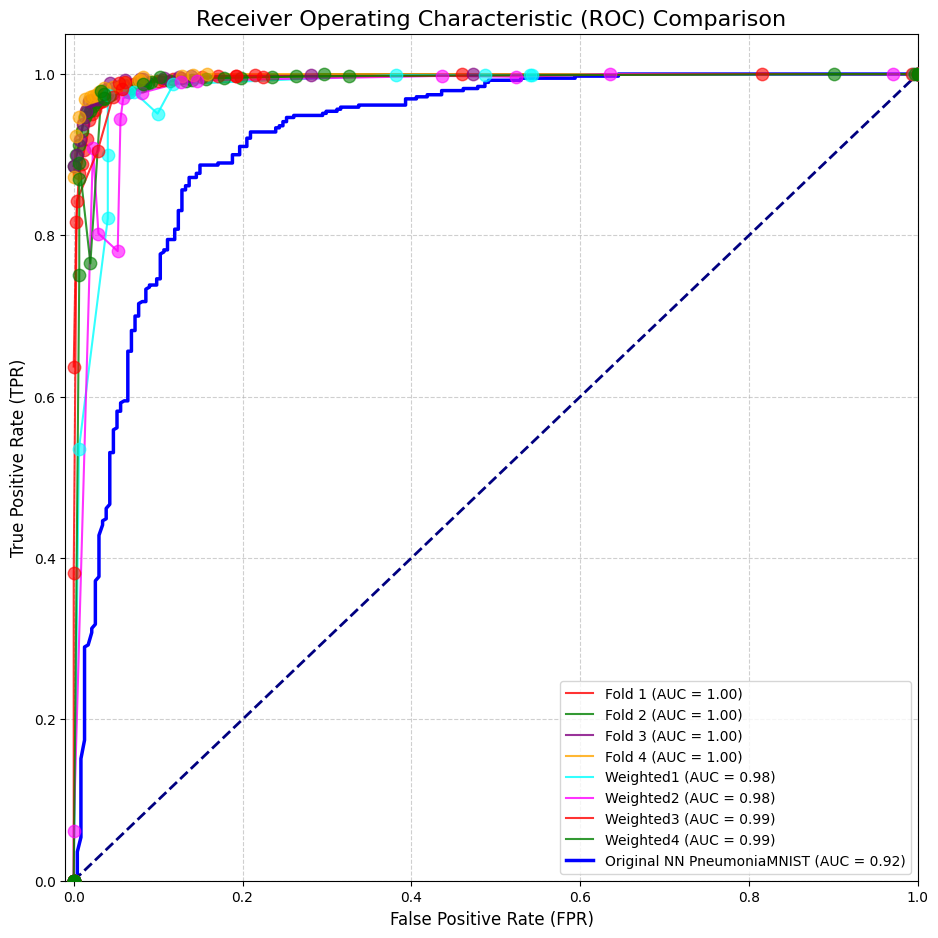

In [15]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4"],
    results_original_roc=results_original_roc
)

### Ensemble prediction using voting

In [16]:


# --- Loop through all the FPR values to generate the ensemble ROC curve ---

ensemble_results_soft = []
ensemble_results_hard = []

print("\n--- Generating Ensemble ROC Curve by iterating through FPR values ---")
# We iterate from a low to high target_fpr to trace the curve
for target_fpr in np.linspace(0.0, 1.0, 50): 
    # 1. Assign the function's output to a single variable first.
    result_tuple = predict_ensemble_and_evaluate(
        list_folds_best_models=list_folds_best_models,
        test_loader=test_loader,
        target_fpr=target_fpr
    )
    
    if result_tuple is not None:
        
        for voting_method, metrics in result_tuple.items():
            # Create a dictionary for each point and append it to the list
            if voting_method == 'soft_voting':
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_soft.append(point_dict)
            else:
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_hard.append(point_dict)
            
        
# Ensure the curve starts at (0, 0)
    if not ensemble_results_soft or ensemble_results_soft[0]['fpr'] > 0.0:
        ensemble_results_soft.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_soft[-1]['fpr'] < 1.0 or ensemble_results_soft[-1]['tpr'] < 1.0:
        ensemble_results_soft.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    if not ensemble_results_hard or ensemble_results_hard[0]['fpr'] > 0.0:
        ensemble_results_hard.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_hard[-1]['fpr'] < 1.0 or ensemble_results_hard[-1]['tpr'] < 1.0:
        ensemble_results_hard.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })







--- Generating Ensemble ROC Curve by iterating through FPR values ---
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 624 samples.


--- Ensemble Results ---
Target FPR: 0.0000
Soft Voting -> Achieved [TPR: 0.0000, FPR: 0.0000]
Hard Voting -> Resulted in [TPR: 0.0000, FPR: 0.0000]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 624 samples.


--- Ensemble Results ---
Target FPR: 0.0204
Soft Voting -> Achieved [TPR: 0.0205, FPR: 0.0214]
Hard Voting -> Resulted in [TPR: 0.0000, FPR: 0.0000]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 624 samples.


--- Ensemble Results ---
Target FPR: 0.0408
Soft Voting -> Achieved [TPR: 0.2795, FPR: 0.0427]
Hard Voting -> Resulted in [TPR: 0.0000, FPR: 0.0000]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 624 samples.


--- Ensemble Results ---
Target FPR: 0.0612
Soft Voting -> Achieved [TPR: 


--- Plotting all ROC curves for comparison ---


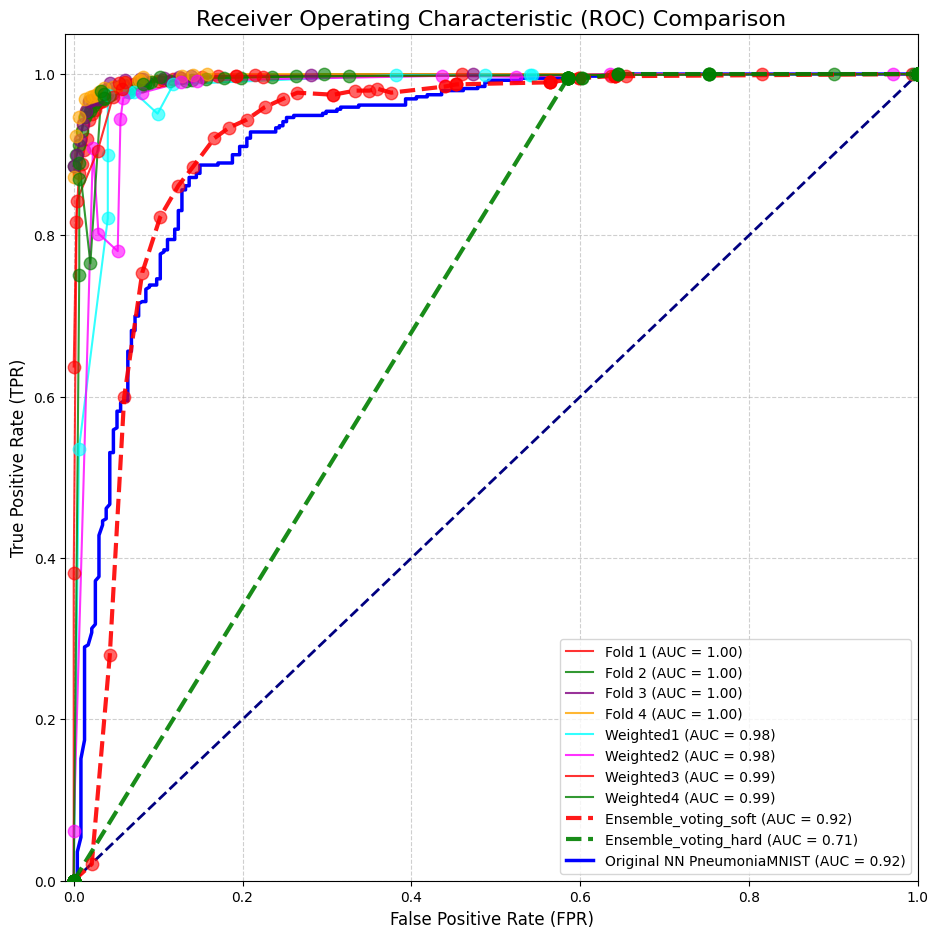

In [17]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(ensemble_results_soft)
results_lists.append(ensemble_results_hard)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Ensemble_voting_soft", "Ensemble_voting_hard"],
    results_original_roc=results_original_roc
)